In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima

# Stock selection and date generation.
stock = str(input("Stock: "))
source = 'yahoo'
y = int(input("Start Year: "))
m = int(input("Start Month: "))
d = int(input("Start Date: "))
start_date = datetime(y, m, d)
end_date = datetime.today()
df = web.DataReader(stock, source, start_date, end_date)
timeseries = df['Adj Close']

Stock: MSFT
Start Year: 2020
Start Month: 1
Start Date: 1


In [5]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling St. Dev')
    plt.plot(timeseries, label='Original Data')
    plt.legend(loc="upper left")
    plt.show(block = False)
    adft = adfuller(timeseries, autolag='AIC')
    idx = ['Test Statistics', 'P-Value', '# Lags', '# Observations']
    output = pd.Series(adft[0:4], index=idx)
    for key, value in adft[4].items():
        output['critical value (%s)' % key] = value
    print(output)

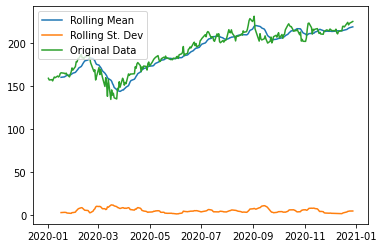

Test Statistics          -1.270503
P-Value                   0.642557
# Lags                    9.000000
# Observations          240.000000
critical value (1%)      -3.457894
critical value (5%)      -2.873659
critical value (10%)     -2.573229
dtype: float64


In [6]:
test_stationarity(timeseries)

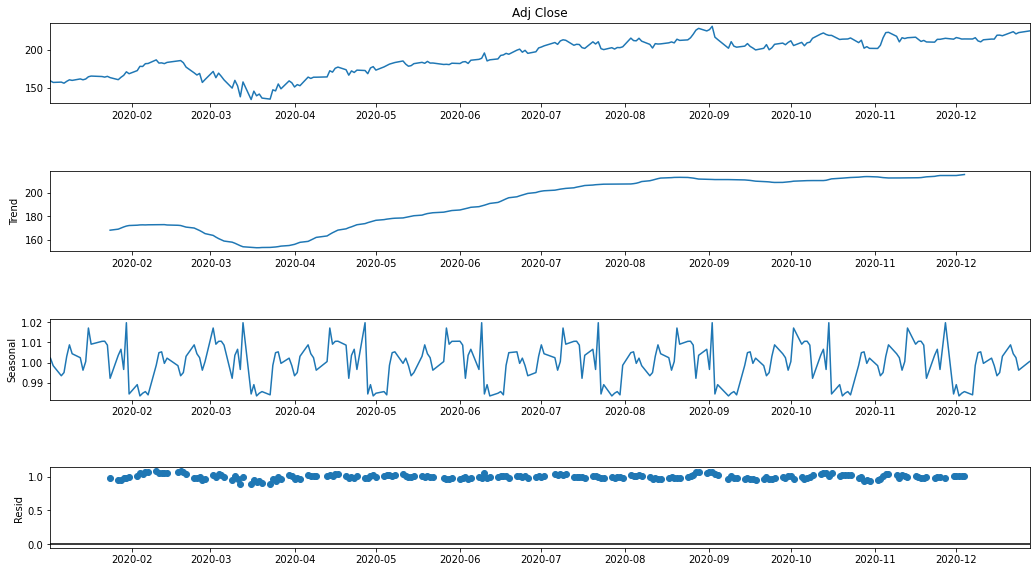

In [8]:
sd = seasonal_decompose(timeseries, model='multiplicative', period=30)
fig = sd.plot()
fig.set_size_inches(16,9)
plt.show()

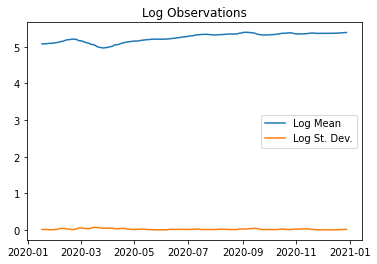

In [15]:
df_log = np.log(timeseries)
log_mean = df_log.rolling(12).mean()
log_std = df_log.rolling(12).std()
plt.plot(log_mean, label='Log Mean')
plt.plot(log_std, label='Log St. Dev.')
plt.legend(loc='right')
plt.title("Log Observations")
plt.show()

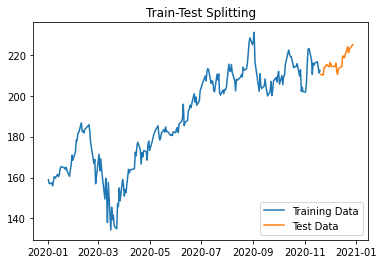

In [16]:
break_point = int(len(timeseries) * 0.9)
train_data, test_data = timeseries[0:break_point], timeseries[break_point:]
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.legend(loc='lower right')
plt.title("Train-Test Splitting")

plt.show()

In [19]:
import warnings
warnings.filterwarnings("ignore")
m_AA = auto_arima(timeseries)

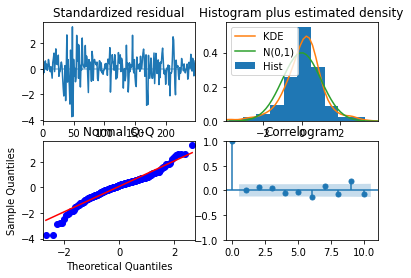

In [20]:
m_AA.plot_diagnostics()
plt.show()

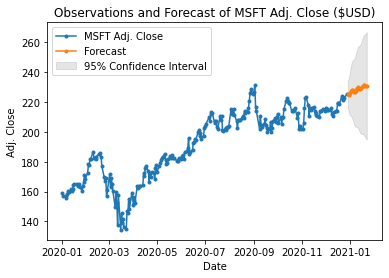

In [37]:
# Model fitting.
model = ARIMA(train_data, order=(3,1,2)).fit(disp=-1)

# Date generation for forecasting.
tdf = int(len(test_data))
dates_list = []
for x in range(0, tdf):
    dates_list.append(end_date + timedelta(days=x))
dates_list = pd.Series(dates_list)
dates_list.index = dates_list.values

# Now for the fun part.
fc, se, conf = model.forecast(tdl, alpha=0.05)
fc = pd.Series(fc, index=dates_list.index)
fc_diff = timeseries[-1] - fc[0]
fc_series = fc + fc_diff
lower_series = conf[:,0] + fc_diff
upper_series = conf[:,1] + fc_diff
plt.plot(timeseries, label='MSFT Adj. Close', marker=".")
plt.plot(fc_series, label='Forecast', marker=".")
plt.fill_between(dates_list.index, lower_series, upper_series, color='k', alpha=0.1, label='95% Confidence Interval')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Adj. Close')
plt.title("Observations and Forecast of MSFT Adj. Close ($USD)")
plt.show()